In [7]:
# 모델 생성
from tensorflow.keras.models import Sequential, Model

# layer 네트워크 
from tensorflow.keras.layers import Reshape, concatenate, Activation, LeakyReLU, Conv2D, Input, MaxPool2D, BatchNormalization, Flatten, Dense, Lambda

# Optimizer
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

# 네트워크 추가 설정 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# 백엔드 함수
import tensorflow.keras.backend as K

# tensorflow
import tensorflow as tf

# Image Data Augmentation을 편하게 해주는 라이브러리
import imgaug

# 기본 라이브러리
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import cv2

# 사용자 라이브러리
from utils import WeightReader, decode_netout, draw_boxes

from preprocessing import parse_annotation, BatchGenerator



### 람다 함수
- 런타임에 생성해서 사용할 수 있는 익명 함수
- 쓰고 버리는 일시적인 함수
- 간단한 기능 
- lambda 인자 : 표현식

In [11]:
d = (lambda x,y: x+y)

In [12]:
d(10,30)

40

In [13]:
g = lambda args: args[0]

In [14]:
b = np.array([1,2,3,4])

In [16]:
IMAGE_H, IMAGE_W = 416, 416
TRUE_BOX_BUFFER  = 50

In [17]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [22]:
input_image.shape

TensorShape([None, 416, 416, 3])

In [23]:
true_boxes.shape

TensorShape([None, 1, 1, 1, 50, 4])

In [20]:
true_boxes.shape

TensorShape([None, 1, 1, 1, 50, 4])

In [27]:
Lambda(lambda args: args[0])([input_image,true_boxes])

<tf.Tensor 'lambda_4/Identity:0' shape=(None, 416, 416, 3) dtype=float32>

In [ ]:
(None, 13, 13, 5, 85)

In [ ]:
1,13,13,5

In [ ]:
0 13,13,

In [238]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 
          'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 
          'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
          'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 
          'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 
          'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 
          'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 
          'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
          'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
          'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [36]:
cell_x = tf.compat.v1.to_float(tf.compat.v1.reshape(tf.compat.v1.tile(tf.compat.v1.range(GRID_W), [GRID_H]),(1, GRID_H,GRID_W,1,1)))
cell_y = tf.compat.v1.transpose(cell_x, (0,2,1,3,4))

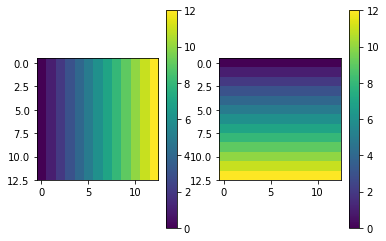

In [813]:
plt.subplot(1,2,1)
plt.imshow(cell_x[0,:,:,0,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(cell_y[0,:,:,0,0])
plt.colorbar()
plt.show()

In [ ]:
a = tf.constant([[1,2,3],[4,5,6]], tf.int32)
b = tf.constant([1,2], tf.int32)
tf.tile(a, b)
<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6]], dtype=int32)>
c = tf.constant([2,1], tf.int32)

In [67]:
a = tf.compat.v1.constant([[1,2,3],[4,5,6]], tf.int32)
print(a)
print(a.shape)

b = tf.compat.v1.constant([2,3], tf.int32)

c = tf.compat.v1.tile(a,b)
print(c)
print(c.shape)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
(2, 3)
tf.Tensor(
[[1 2 3 1 2 3 1 2 3]
 [4 5 6 4 5 6 4 5 6]
 [1 2 3 1 2 3 1 2 3]
 [4 5 6 4 5 6 4 5 6]], shape=(4, 9), dtype=int32)
(4, 9)


In [77]:
mask = tf.compat.v1.constant((50, 13, 13, 5, 85))[:4]

In [78]:
mask

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([50, 13, 13,  5], dtype=int32)>

In [53]:
cell_grid = tf.compat.v1.tile(tf.compat.v1.concat([cell_x,cell_y],-1),[BATCH_SIZE, 1,1,5,1])

In [55]:
tf.compat.v1.concat([cell_x,cell_y],-1).shape

TensorShape([1, 13, 13, 1, 2])

In [62]:
cell_grid.shape

TensorShape([16, 13, 13, 5, 2])

In [181]:
coord_mask = tf.compat.v1.zeros(mask)
conf_mask = tf.compat.v1.zeros(mask)
class_mask = tf.compat.v1.zeros(mask)

In [83]:
seen = tf.compat.v1.Variable(0.)

In [85]:
total_recall = tf.Variable(0.)

In [816]:
y_pred = tf.compat.v1.ones((BATCH_SIZE,13,13,5,85))

In [817]:
y_pred[...,2:4].shape

TensorShape([16, 13, 13, 5, 2])

In [818]:
pred_box_xy = tf.compat.v1.sigmoid(y_pred[:,:,:,:,:2]) + cell_grid

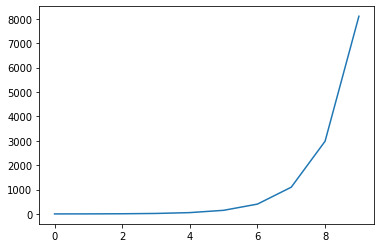

In [819]:
x = np.arange(0,10,1)
y = np.exp(x)
plt.plot(x,y)

In [820]:
ANCHORS

[0.57273,
 0.677385,
 1.87446,
 2.06253,
 3.33843,
 5.47434,
 7.88282,
 3.52778,
 9.77052,
 9.16828]

In [821]:
pred_box_wh = tf.compat.v1.exp(y_pred[...,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])

In [822]:
y_pred.shape

TensorShape([16, 13, 13, 5, 85])

In [823]:
pred_box_xy.shape

TensorShape([16, 13, 13, 5, 2])

In [824]:
pred_box_wh.shape

TensorShape([16, 13, 13, 5, 2])

In [825]:
y_pred[...,4].shape

TensorShape([16, 13, 13, 5])

In [826]:
pred_box_conf = tf.sigmoid(y_pred[...,4])

In [827]:
pred_box_class = y_pred[...,5:]

In [828]:
pred_box_xy.shape

TensorShape([16, 13, 13, 5, 2])

In [829]:
pred_box_wh.shape

TensorShape([16, 13, 13, 5, 2])

In [830]:
pred_box_conf.shape

TensorShape([16, 13, 13, 5])

In [831]:
pred_box_class.shape

TensorShape([16, 13, 13, 5, 80])

In [134]:
y_true = tf.compat.v1.ones((BATCH_SIZE,13,13,5,85))

In [135]:
y_true.shape

TensorShape([16, 13, 13, 5, 85])

In [214]:
y_true[...,5:].shape

TensorShape([16, 13, 13, 5, 80])

In [213]:
tf.argmax(y_true[...,5:],-1).shape

TensorShape([16, 13, 13, 5])

In [218]:
true_box_class.shape

TensorShape([16, 13, 13, 5, 80])

In [231]:
true_box_class.shape

TensorShape([16, 13, 13, 5])

In [229]:
CLASS_WEIGHTS.shape

(80,)

In [243]:
c1 = tf.compat.v1.constant([1,3,5,7,9,0,2,4,6,8])
c2 = tf.compat.v1.constant([1,3,5,8,9,10])
v1 = tf.compat.v1.constant([[1,2,3,4,5,6],[7,8,9,0,1,2]])
v2 = tf.compat.v1.constant([[1,2,3],[7,8,9]])


In [253]:
tf.compat.v1.gather(v1,[[0,1],[0,0]])

<tf.Tensor: shape=(2, 2, 6), dtype=int32, numpy=
array([[[1, 2, 3, 4, 5, 6],
        [7, 8, 9, 0, 1, 2]],

       [[1, 2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5, 6]]], dtype=int32)>

In [277]:
(y_true[...,4] * tf.compat.v1.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE ).shape     
    

TensorShape([16, 13, 13, 5])

In [278]:
class_mask.shape

TensorShape([50, 13, 13, 5])

In [244]:
tf.compat.v1.gather(c2,[2,5,2,5])

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 5, 10,  5, 10], dtype=int32)>

In [268]:
tf.compat.v1.reduce_sum(tf.compat.v1.to_float(np.array([1,2,3,4,-1])>0.0) ) + 1e-6

<tf.Tensor: shape=(), dtype=float32, numpy=4.000001>

In [254]:
true_box_class * tru

TensorShape([16, 13, 13, 5])

In [258]:
(y_true[...,4] * tf.compat.v1.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE)

TensorShape([16, 13, 13, 5])

In [336]:
import xml.etree.ElementTree as ET

In [343]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

In [356]:
all_imgs, seen_labels = parse_annotation(anno_path,image_path)

In [ ]:
true_box_xy = y_true[...,0:2]
true_box_wh = y_true[...,2:4]
true_box_class = tf.compat.v1.argmax(y_true[...,5:],-1)

In [364]:
def normalize(image):
    return image / 255.

In [371]:
np.shape(all_imgs[:100])

(100,)

In [370]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [544]:
train_batch = BatchGenerator(all_imgs[100:200],generator_config,norm=normalize)

/Users/changmin.kim/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [573]:
result = next(iter(train_batch))

In [574]:
result[1].shape

(16, 13, 13, 5, 85)

In [781]:
num = 0

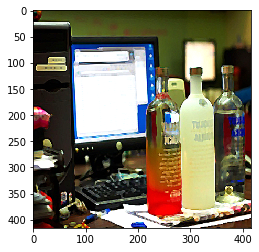

In [782]:
plt.imshow(result[0][0][num]) # train_image

In [783]:
result[0][1][num][0,0,0,:7,:] # true boxes(x,y,w,h)

array([[11.78125 ,  7.34375 ,  1.875   ,  8.125   ],
       [ 9.859375,  7.609375,  1.96875 ,  8.53125 ],
       [ 7.828125,  7.765625,  2.21875 ,  8.90625 ],
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ]])

In [784]:
5 -> object_machine 개수
0~85 -> 0:x, 1:y, w:2, h:3, c:4 clas:5~84

SyntaxError: invalid syntax (<ipython-input-784-a62a909df9eb>, line 1)

In [832]:
y_true = result[1]

In [833]:
# adjust xy
true_box_xy = y_true[...,0:2] # xy (relative position to the containing cell)
# adjust wh
true_box_wh = y_true[...,2:4] # wh (number of cells accross, horizontally and vertically)

# adjust confidence
true_wh_half = true_box_wh/2.
true_mins = true_box_xy - true_wh_half
true_maxes = true_box_xy + true_wh_half

pred_wh_half = pred_box_wh/2.
pred_mins = pred_box_xy - pred_wh_half
pred_maxes = pred_box_xy + pred_wh_half

intersect_mins  = tf.compat.v1.maximum(pred_mins,  true_mins)
intersect_maxes = tf.compat.v1.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.compat.v1.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.compat.v1.truediv(intersect_areas, union_areas)

true_box_conf = iou_scores * y_true[..., 4]

# adjust class probabilities
true_box_class = tf.compat.v1.argmax(y_true[...,5:],-1) #

In [834]:
print(true_box_xy.shape)
print(true_box_wh.shape)
print(true_box_conf.shape)
print(true_box_class.shape)

(16, 13, 13, 5, 2)
(16, 13, 13, 5, 2)
(16, 13, 13, 5)
(16, 13, 13, 5)


In [835]:
true_boxes = result[0][1]

In [869]:
pred_mins[0].shape

TensorShape([13, 13, 5, 1, 2])

In [867]:
true_mins[0].shape

(1, 1, 1, 50, 2)

In [868]:
intersect_maxes[0].shape

TensorShape([13, 13, 5, 50, 2])

In [872]:
intersect_areas.shape

TensorShape([16, 13, 13, 5, 50])

In [877]:
conf_mask.shape

TensorShape([50, 13, 13, 5])

In [920]:
mask_shape = tf.compat.v1.shape(y_true)[:4]

cell_x = tf.compat.v1.to_float(tf.compat.v1.reshape(tf.compat.v1.tile(tf.compat.v1.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
cell_y = tf.compat.v1.transpose(cell_x, (0,2,1,3,4))

cell_grid = tf.compat.v1.tile(tf.compat.v1.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

coord_mask = tf.compat.v1.zeros(mask_shape)
conf_mask  = tf.compat.v1.zeros(mask_shape)
class_mask = tf.compat.v1.zeros(mask_shape)

In [921]:
### coordinate mask: simply the position of the ground truth boxes (the predictors)
coord_mask = tf.expand_dims(y_true[...,4],axis=-1) * COORD_SCALE

# penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
true_xy = true_boxes[...,0:2]
true_wh = true_boxes[...,2:4]

true_wh_half = true_wh / 2.
true_mins = true_xy - true_wh_half
true_maxes = true_xy + true_wh_half

pred_xy = tf.compat.v1.expand_dims(pred_box_xy, 4)
pred_wh = tf.compat.v1.expand_dims(pred_box_wh, 4)
    
pred_wh_half = pred_wh / 2.
pred_mins    = pred_xy - pred_wh_half
pred_maxes   = pred_xy + pred_wh_half   

intersect_mins  = tf.compat.v1.maximum(pred_mins,  true_mins)
intersect_maxes = tf.compat.v1.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.compat.v1.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_wh[..., 0] * true_wh[..., 1]
pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.compat.v1.truediv(intersect_areas, union_areas)

best_ious = tf.compat.v1.reduce_max(iou_scores, axis=4)
conf_mask = conf_mask + tf.compat.v1.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE

# penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE

### class mask: simply the position of the ground truth boxes (the predictors)
class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE  

In [918]:
(tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE).shape

TensorShape([16, 13, 13, 5, 1])

In [923]:
coord_mask.shape

TensorShape([16, 13, 13, 5, 1])

In [922]:
class_mask.shape

TensorShape([16, 13, 13, 5])

In [903]:
np.unique(tf.compat.v1.gather(CLASS_WEIGHTS,true_box_class))

array([1.], dtype=float32)

In [914]:
y_true[..., 4].shape

(16, 13, 13, 5)

In [913]:
true_box_class[0]a

<tf.Tensor: shape=(13, 13, 5), dtype=int64, numpy=
array([[[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0

In [907]:
np.unique(class_mask)

array([0., 1.], dtype=float32)

In [896]:
iou_scores.shape

TensorShape([16, 13, 13, 5, 50])

In [898]:
best_ious[0,:,:,0]

<tf.Tensor: shape=(13, 13), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01199649, 0.02389727, 0.01498591, 0.02499393,
        0.01415487, 0.03291228, 0.01592965],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04909772, 0.10149496, 0.06189791, 0.11552667,
        0.06301283, 0.13362233, 0.06157578],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.06877147, 0.14506789, 0.08712674, 0.17067543,
        0.09104712, 0.18816966, 0.08451945],
       [0.        , 0.        , 0.        , 0

In [895]:
best_ious < 0.6

<tf.Tensor: shape=(16, 13, 13, 5), dtype=bool, numpy=
array([[[[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         ...,
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         ...,
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         ...,
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True]],

        ...,

        [[ True,  True,  True,  True,  True],
         [

In [894]:
tf.compat.v1.to_float(best_ious < 0.6)

<tf.Tensor: shape=(16, 13, 13, 5), dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        ...,

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         ...,
         [1., 

In [892]:
16* 13*13*5

13520

In [893]:
NO_OBJECT_SCALE

1.0

In [890]:
np.sum(tf.compat.v1.to_float(best_ious < 0.6))

13471.0

In [862]:
intersect_maxes[0][:,:,0,0,:]

<tf.Tensor: shape=(13, 13, 2), dtype=float32, numpy=
array([[[ 1.5094793,  1.6517203],
        [ 2.5094793,  1.6517203],
        [ 3.5094793,  1.6517203],
        [ 4.5094795,  1.6517203],
        [ 5.5094795,  1.6517203],
        [ 6.5094795,  1.6517203],
        [ 7.5094795,  1.6517203],
        [ 8.5094795,  1.6517203],
        [ 9.509479 ,  1.6517203],
        [10.509479 ,  1.6517203],
        [11.509479 ,  1.6517203],
        [12.509479 ,  1.6517203],
        [12.71875  ,  1.6517203]],

       [[ 1.5094793,  2.6517203],
        [ 2.5094793,  2.6517203],
        [ 3.5094793,  2.6517203],
        [ 4.5094795,  2.6517203],
        [ 5.5094795,  2.6517203],
        [ 6.5094795,  2.6517203],
        [ 7.5094795,  2.6517203],
        [ 8.5094795,  2.6517203],
        [ 9.509479 ,  2.6517203],
        [10.509479 ,  2.6517203],
        [11.509479 ,  2.6517203],
        [12.509479 ,  2.6517203],
        [12.71875  ,  2.6517203]],

       [[ 1.5094793,  3.6517203],
        [ 2.5094793,  3.6

In [761]:
np.unique(tf.argmax(y_true[...,5:],-1))

array([ 0,  2, 14, 16, 18, 19, 39, 56])

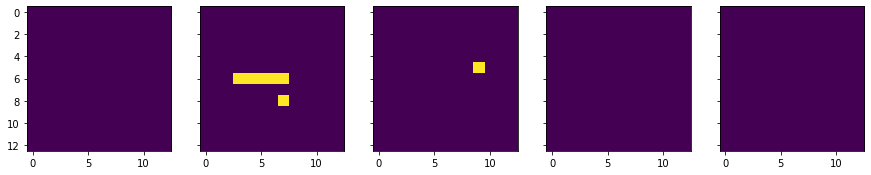

In [746]:
fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
for i in range(5):
    axs[i].imshow(result[1][num][:,:,i,4]) # train_label
plt.show()


In [347]:
anno_path = '/Users/changmin.kim/Downloads/VOC2012/Annotations/'
image_path = '/Users/changmin.kim/Downloads/VOC2012/JPEGImages/'

In [295]:
img = {'object':[]}

In [304]:
img['object'] +='b'

In [332]:
gg = []

In [333]:
gg+='a'
gg+='b'

In [334]:
gg.append('a')
gg.append('b')

In [335]:
gg

['a', 'b', 'a', 'b']

In [306]:
img['object']

['a', 'b']

In [297]:
img['filename'] = "b"

In [298]:
img

{'object': [], 'filename': 'b'}

In [292]:
a['info']

{'description': 'COCO 2014 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2014,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [279]:
true_box_class.shape

TensorShape([16, 13, 13, 5])

In [141]:
pred_mins.shape

TensorShape([16, 13, 13, 5, 2])

In [146]:
tf.compat.v1.maximum([[1,2,3],[2,7,9]],[[10,4,1],[10,2,7]])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[10,  4,  3],
       [10,  7,  9]], dtype=int32)>

In [165]:
intersect_mins = tf.compat.v1.maximum(pred_mins, true_mins)
intersect_maxes = tf.compat.v1.minimum(pred_maxes, true_maxes)
intersect_wh = tf.compat.v1.maximum(intersect_maxes - intersect_mins,0.)

intersect_areas = intersect_wh[...,0] * intersect_wh[...,1]

true_areas = true_box_wh[...,0] * true_box_wh[...,1]
pred_areas = pred_box_wh[...,0] * pred_box_wh[...,1]

union_areas = pred_areas + true_areas - intersect_areas


In [172]:
import operator


In [174]:
2/3

0.6666666666666666

In [173]:
operator.truediv(2,3)

0.6666666666666666

In [166]:
iou_scores = tf.compat.v1.truediv(intersect_areas,union_areas)

In [168]:
true_conf = iou_scores * y_true[...,4]

In [ ]:
coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)

In [183]:
coord_mask = tf.compat.v1.expand_dims(y_true[...,4], axis=-1) * COORD_SCALE

In [197]:
true_box_xy.shape

TensorShape([16, 13, 13, 5, 2])

In [198]:
true_boxes.shape

TensorShape([None, 1, 1, 1, 50, 4])

In [199]:
true_xy = true_boxes[..., 0:2]
true_wh = true_boxes[..., 2:4]

In [204]:
tf.compat.v1.expand_dims(pred_box_xy,4).shape

TensorShape([16, 13, 13, 5, 1, 2])

In [205]:
true_wh_half = true_wh /2.
true_mins = true_xy - true_wh_half
true_maxes = true_xy + true_wh_half

pred_xy = tf.compat.v1.expand_dims(pred_box_xy,4)
pred_wh = tf.compat.v1.expand_dims(pred_box_wh,4)